In [379]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

== input ==

In [380]:
x_min = -20000
x_max = +20000
x_num = 50

xV = np.linspace(x_min, x_max, x_num)

In [381]:
m = 1.3
b = 1000

a = 50
T = 4000

n = 100

yV_lin = m * xV + b
yV_exp = np.sign(xV) * a * (np.exp(abs(xV)/T) - 1)
yV_noi = n * np.random.normal(size=xV.size)

yV = yV_lin + yV_exp + yV_noi


== polynomial fit ==

In [382]:
deg = 13

f = np.poly1d(np.polyfit(xV, yV, deg=deg))
yfV = f(xV)

== custom fit ==

In [383]:
start_order = 1
stop_order = 13

xM = np.vstack([xV**i for i in range(start_order, stop_order+1)]).T
coeff = np.linalg.solve(xM.T @ xM, xM.T @ yV)
ygV = xM @ coeff

== plot ==

In [384]:
def plot(xV, yV, fV_list=None):
    _, ax = plt.subplots(figsize=(16, 16))
    colors = ['-r', '-g']
    ax.axvline(x=0, color='k')
    ax.axhline(y=0, color='k')
    ax.plot(xV, xV, 'k', label='ideal')
    ax.plot(xV, yV, '.b', label='data')
    if fV_list:
        for num, (fV, name) in enumerate(fV_list):
            ax.plot(xV, fV, colors[num % len(colors)], label=name)
    ax.legend()
    plt.show()

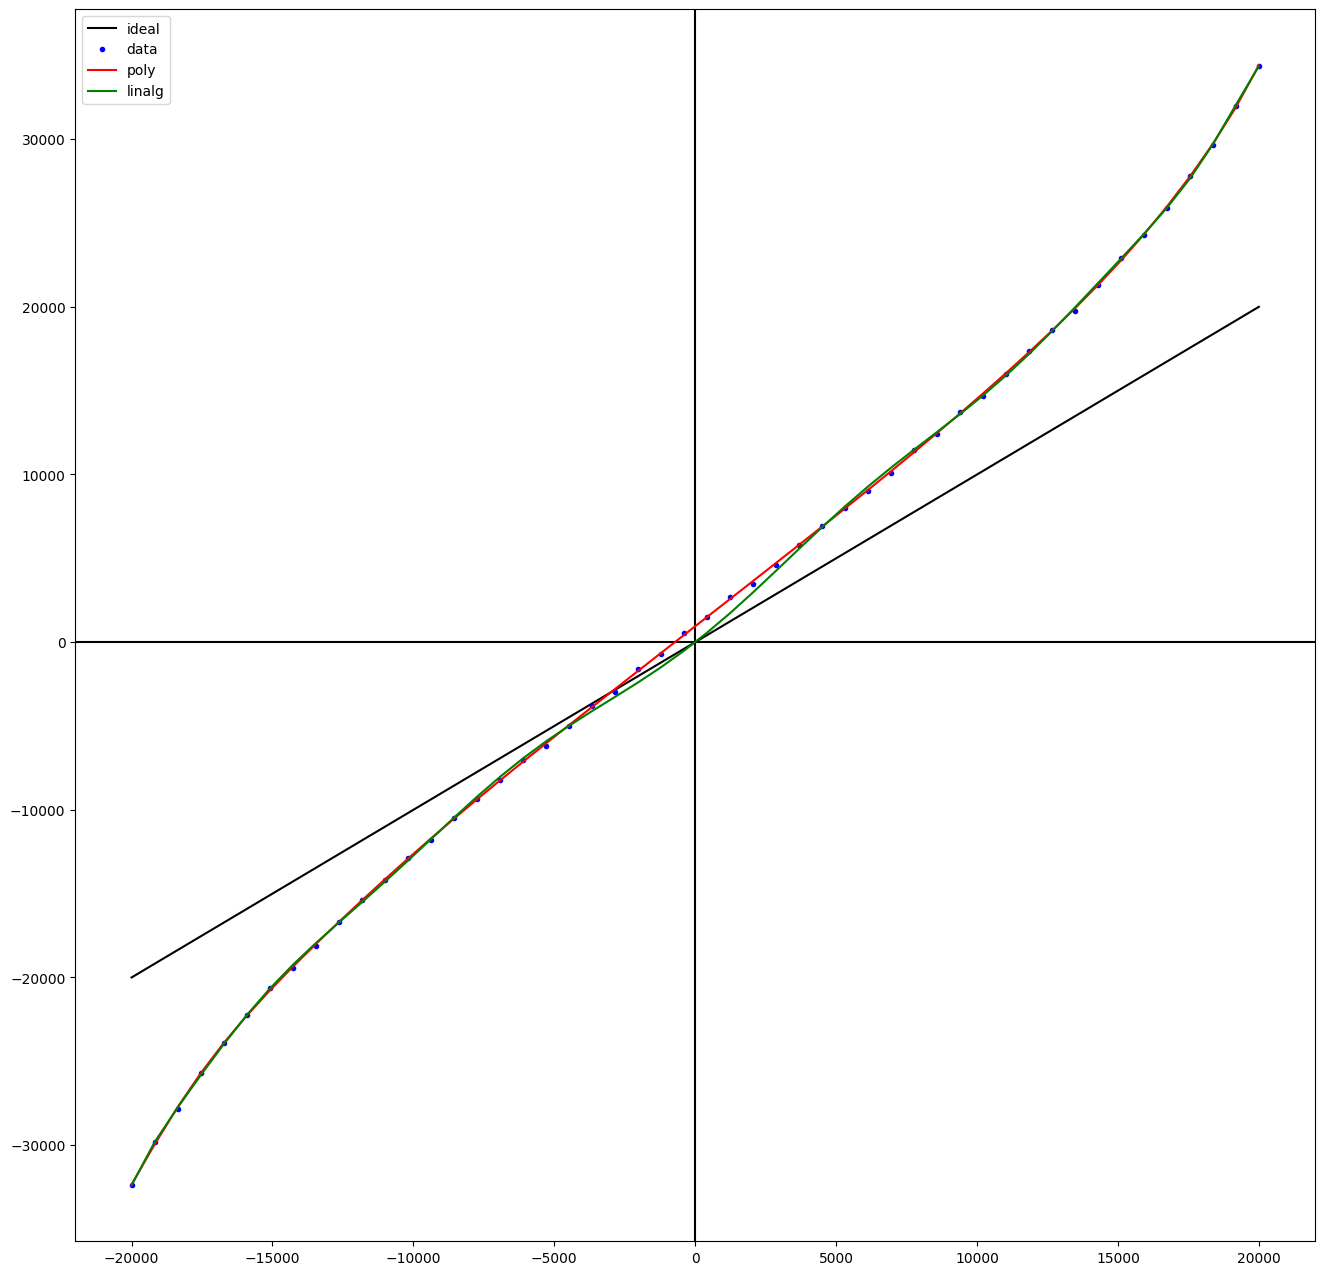

In [385]:
plot(xV, yV, [(yfV, 'poly'), (ygV, 'linalg')])